# 3. Clinical Application

### Contents


- Code presents an adapted version of the pulse rate estimation algorithm previously presented 
- Project Write-up describing the clinical significance observed from the proposed algorithm applied to this dataset and what ways/information could improve your results


### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years [1]. This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable [2].

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

## 3.1 Code

In [2]:
# Importing packages

import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. These files are used to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. This file is used to make the association between resting heart rate and age group for each gender.

In [3]:
hr_filenames = glob.glob('/data/crisdb/*.npz')
hr_filenames

['/data/crisdb/e190a.npz',
 '/data/crisdb/e014b.npz',
 '/data/crisdb/m169b.npz',
 '/data/crisdb/e057a.npz',
 '/data/crisdb/e093b.npz',
 '/data/crisdb/m207b.npz',
 '/data/crisdb/e247a.npz',
 '/data/crisdb/e071b.npz',
 '/data/crisdb/m165a.npz',
 '/data/crisdb/e281b.npz',
 '/data/crisdb/f228a.npz',
 '/data/crisdb/f049a.npz',
 '/data/crisdb/f122b.npz',
 '/data/crisdb/e156b.npz',
 '/data/crisdb/f031b.npz',
 '/data/crisdb/m026a.npz',
 '/data/crisdb/f105a.npz',
 '/data/crisdb/m258a.npz',
 '/data/crisdb/m216b.npz',
 '/data/crisdb/e217b.npz',
 '/data/crisdb/f119b.npz',
 '/data/crisdb/f176a.npz',
 '/data/crisdb/m218b.npz',
 '/data/crisdb/m212b.npz',
 '/data/crisdb/e104b.npz',
 '/data/crisdb/m063a.npz',
 '/data/crisdb/m279a.npz',
 '/data/crisdb/f193b.npz',
 '/data/crisdb/f108b.npz',
 '/data/crisdb/f128a.npz',
 '/data/crisdb/e256a.npz',
 '/data/crisdb/f100b.npz',
 '/data/crisdb/e245b.npz',
 '/data/crisdb/m275a.npz',
 '/data/crisdb/m063b.npz',
 '/data/crisdb/m234b.npz',
 '/data/crisdb/f176b.npz',
 

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

         ID    Age     Sex
0     e198a  20-24    Male
1     e198b  20-24    Male
2     e028b  30-34    Male
3     e028a  30-34    Male
4     e061b  30-34    Male
5     e061a  30-34    Male
6     e265b  35-39    Male
7     e033b  35-39    Male
8     e265a  35-39    Male
9     e033a  35-39    Male
10    e146b  35-39  Female
11    e146a  35-39  Female
12    e152b  35-39    Male
13    e152a  35-39    Male
14    e221b  35-39    Male
15    e186a  35-39    Male
16    e132b  35-39    Male
17    e082a  35-39    Male
18    e221a  35-39    Male
19    e186b  35-39    Male
20    e132a  35-39    Male
21    e082b  35-39    Male
22    f074b  35-39    Male
23    f057b  35-39    Male
24    f057a  35-39    Male
25    m137b  35-39    Male
26    m137a  35-39    Male
27    m063b  35-39    Male
28    m063a  35-39    Male
29    m255b  35-39    Male
...     ...    ...     ...
1513  m072b  75-79    Male
1514  m249b  75-79    Male
1515  m273a  75-79    Male
1516  m072a  75-79    Male
1517  m249a  75-79    Male
1

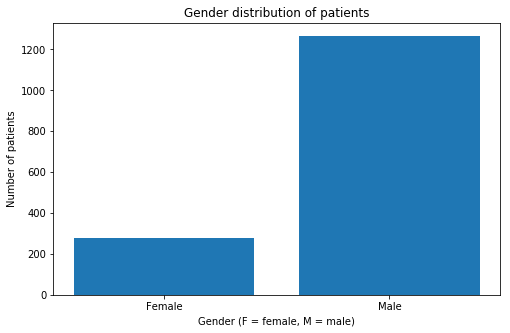

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    sub_id, age, sex = [], [], []
    f.readline()

    j = 0
    for line in f:
        
        line = line.strip()
        sub_id.append(line[0:5])
        age.append(line[6:11])
        sex.append(line[12:18])
        
        j += 1 

df_metadata = pd.DataFrame(columns=["ID", "Age", "Sex"])
df_metadata["ID"] = sub_id
df_metadata["Age"] = age
df_metadata["Sex"] = sex

print(df_metadata)
print(df_metadata["Sex"].value_counts(ascending=True))

# Gender distribution

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(np.unique(df_metadata["Sex"]), df_metadata["Sex"].value_counts(ascending=True));
ax.set(title="Gender distribution of patients",
      xlabel="Gender (F = female, M = male)",
      ylabel="Number of patients");

#### Compute Resting Heart Rate
For each subject, the resting heart rate is computed while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [7]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
   
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.min(np.percentile(hr_data, 5))

    # Find the subject ID from the filename.
    subject = filename.replace("/data/crisdb/", "").replace(".npz", "")
    
    # Find the age group for this subject in metadata.
    age_group = df_metadata[df_metadata["ID"] == subject]["Age"].values[0]

    # Find the sex for this subject in metadata.
    sex = df_metadata[df_metadata["ID"] == subject]["Sex"].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(df_metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])
df

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604
5,70-74,Male,53.333333
6,45-49,Male,46.265060
7,60-64,Male,75.031806
8,70-74,Male,62.715006
9,65-69,Male,70.520572


#### Plot Resting Heart Rate vs. Age Group
The [seaborn](https://seaborn.pydata.org/) package is used to plot the relationship. Seaborn is a thin wrapper around matplotlib that enables higher-level statistical plots.

[Lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) is used to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean.

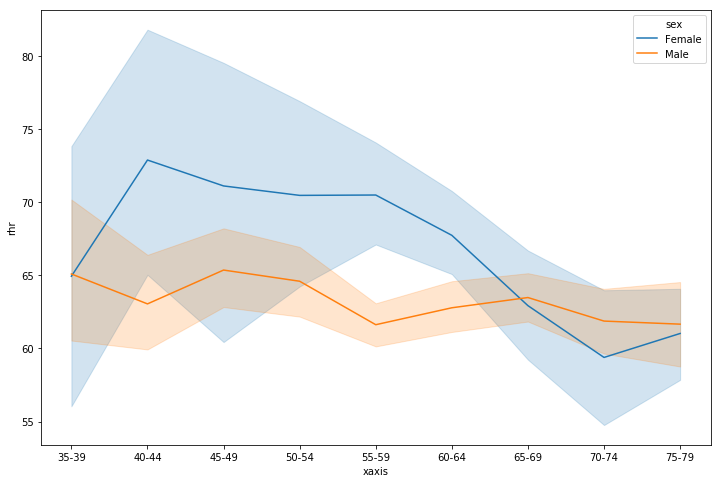

In [8]:
labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

In [3]:
import sys
!pip install seaborn==0.9.0

## 3.2 Project Write-up

#### Clinical Conclusions

* For women, a general increase is seen in the mean value of the heart rate from 40 years with a huge variability. Both values decrease around the age of 55. 

* For men, there is a more stable mean value and less variability through time. 

* In comparison to men, women's heart rate shows a higher mean value and variability around the ages of 40-64, while mean and variability values are more comparable for females and males afterwards.

* Some possible reasons for what is seen in the data is the clear unbalanced data. The amount of female subjects is underepresented in comparison with the male subjects included in the data. The high variability and the changes could be due to the lack of a more representative sample of the population in this age group. Another hypothesis could be related to the hormonal changes of females due to menopause in this age period. However, to support this observation, more female subjects need to be included to make a relevant comparison to their male pairs. 

* To improve the results, in general, more data and more relevant information of the subjects would improve our analysis: lifestyle, general physical condition, habits (smoker, sedentary, etc.). In case patients with cardiac conditions are included, deeper knowledge of each patients would be necessary to understand the graphics.

* The known trend of average resting heart rate increasing up until middle age and then decreasing into old age can be seen as a strong statement in this specific case and data, and could be be a valid hypothesis but not a general conclusion. It would be necessary to include more data, more information on the sample and the general condition of these subjects. This could a complement to other larger studies on the subject but it does not stand by itself proving that statement. Finally, we should also pay attention to the fact that in this sample, male subjects do not really show such a trend during middle and old ages.